# ISYE6420 Fall 2019 HW3: Problem 2.b 

---
**Course:** ISYE6420                 
**Term:** Fall 2019    
**Author:** James D. Triveri   
**Date:** 2019-09-29     
**Problem:** 2.b     

---

A description of the mechanics of the implementation can be found in *James_D_Triveri_ISYE6420_HW3_Part_1C_Supplement.pdf*. In short, the `HPD` function identifies the $(1 - \alpha)100\%$ HPD credible set for a specified posterior distribution. The logic here is identical, except the posterior distribution is changed from gamma in problem 1.b to beta for 2.b.

In [1]:
"""
Logic to compute (1-a)100% HPD credible set and associated level k-alpha. 

"""
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, special, optimize



def _beta(a, b):
    """
    Beta distribution closure. Returns a parameterized beta density, which 
    takes a single argument x and returns the corresponding beta PDF 
    evaluated at that point.
    
    Parameters
    ----------
    a: float
        Shape parameter. Must be greater than 0. 
        
    b: float
        Shape parameter. Must be greater than 0. 
    
    """
    def _pdf(x):
        """Evaluate parameterized gamma PDF at x."""
        coeff = special.gamma(a + b) / (special.gamma(a) * special.gamma(b))
        return(coeff * np.power(x, a - 1) * np.power(1 - x, b - 1))
    return(_pdf)



def _intersection(func1, func2, xinit):
    """
    Identify the points of intersection for func1 and func2. 
    
    Parameters
    ----------
    func1: function
        A callable that takes a single argument. 
        
    func2: function
        A callable that takes a single argument. 
    
    xinit: list
        The starting estimates for the intersection points of func1 and func2. 
    """
    return(optimize.fsolve(lambda x: func1(x) - func2(x), xinit))



def HPD(a, b, alpha=.05, niter=50, tol=1e-8):
    """
    Perform binary search over posterior density in order to identify
    the level k-alpha (1-alpha)100% HPD credible set. 
    
    Parameters
    ----------
    a: float
        Shape parameter. Must be greater than 0. 
        
    b: float
        Shape parameter. Must be greater than 0. 
        
    alpha: float
        The level used to determine the calculated credible set. 
        Identified HPD will correspond to area under posterior density
        equal to 1- alpha. 
    
    niter: int
        The number of iterations to compute prior to terminating. 
        Should rarely exceed 30. 
        
    tol: float
        The equivalence threshold used to indicate when the HPD
        credible set has been identified. 
    
    Returns
    -------
    A dictionary comprised of the following keys:
    
    iterations: int
        Number of iterations before convergence.
    
    k_alpha: float
        The k(alpha) value for which the area under the posterior
        density equals 1 - alpha. 
    
    k_roots: list
        The upper and lower bounds of the (1 - alpha)100% HPD credible set. 
    
    auc: float
        The final area under the posterior density. Bound between [0, 1]. 
    
    alpha: float
        The level used to determine the calculated credible set. Input. 
        
    niter: int
        The number of iterations to compute prior to terminating. Input.
        
    tol: float
        The equivalence threshold used to indicate when the HPD
        credible set has been identified. 
        
    a: float
        Shape parameter. Must be greater than 0. 
        
    b: float
        Shape parameter. Must be greater than 0. 
            
    rv: scipy.stats._distn_infrastructure.rv_frozen
        The frozen, parameterized posterior distribution.
    """ 
    randv      = stats.beta(a=a, b=b) 
    randv_mode = (a - 1) / (a + b - 2)        # mode of distribution
    hpd        = 1 - alpha                    # area under posterior density
    randv_max  = randv.pdf(randv_mode)        # density @ posterior mode
    randv_min  = 0                            # posterior minimum
    xinit   = [randv.ppf(.05), randv.ppf(.95)] # starting estimates
    k_alpha = (randv_max + randv_min) / 2.     # proposed k-alpha
    func1   = _beta(a=a, b=b)                  # density obtained from _beta
    func2   = lambda x: k_alpha                # horizontal line f(x) = k_alpha
    k_roots = _intersection(func1=func1, func2=func2, xinit=xinit) 
    auc     = randv.cdf(k_roots[-1]) - randv.cdf(k_roots[0]) # area under curve

    for i in itertools.count(start=1):
        
        print(
            "[#{}] proposed k({:.2f}):{:.10f} - auc:{:.10f} - [{:.5f}, {:.5f}]".format(
            i, alpha, k_alpha, auc, k_roots[0], k_roots[-1])
            )
        
        if i > niter:
            print("Iteration failed to converge after 50 iterations - exiting.")
            break
    
        if np.abs(auc - hpd) < tol: 
            break
            
        if auc < hpd:
            randv_max, randv_min = k_alpha, randv_min
        else:
            randv_max, randv_min = randv_max, k_alpha
               
        k_alpha = (randv_max + randv_min) / 2.
        k_roots = _intersection(func1=func1, func2=func2, xinit=k_roots)
        auc  = randv.cdf(k_roots[-1]) - randv.cdf(k_roots[0])
        
    dresult = {
        "iterations":i, "k_alpha":k_alpha, "k_roots":k_roots, 
        "auc":auc, "alpha":alpha, "niter":niter, "tol":tol, 
        "a":a, "b":b, "rv":randv
        }
    
    return(dresult)


In [2]:
# Specify parameters and set initial values.
a_prior     = 31.5 # elicited
b_prior     = 3.5  # elicited
a_posterior = 22 + a_prior
b_posterior = 30 - 22 + b_prior
ALPHA       = .05      
NITER       = 50       
TOL         = 1e-8     

# Call HPD and bind references to relevant output.
dresult = HPD(a=a_posterior, b=b_posterior, alpha=ALPHA, niter=NITER, tol=TOL)
kalpha  = dresult["k_alpha"]
kroots  = dresult["k_roots"]
rv      = dresult["rv"]


[#1] proposed k(0.05):4.2805087214 - auc:0.7644950943 - [0.77339, 0.88357]
[#2] proposed k(0.05):2.1402543607 - auc:0.9065802893 - [0.74606, 0.90133]
[#3] proposed k(0.05):1.0701271803 - auc:0.9600829663 - [0.72423, 0.91374]
[#4] proposed k(0.05):1.6051907705 - auc:0.9347403806 - [0.73655, 0.90692]
[#5] proposed k(0.05):1.3376589754 - auc:0.9477729793 - [0.73087, 0.91012]
[#6] proposed k(0.05):1.2038930779 - auc:0.9540203382 - [0.72770, 0.91186]
[#7] proposed k(0.05):1.2707760267 - auc:0.9509194430 - [0.72932, 0.91098]
[#8] proposed k(0.05):1.3042175010 - auc:0.9493518738 - [0.73010, 0.91054]
[#9] proposed k(0.05):1.2874967639 - auc:0.9501370780 - [0.72971, 0.91076]
[#10] proposed k(0.05):1.2958571325 - auc:0.9497448303 - [0.72991, 0.91065]
[#11] proposed k(0.05):1.2916769482 - auc:0.9499410428 - [0.72981, 0.91070]
[#12] proposed k(0.05):1.2895868560 - auc:0.9500390826 - [0.72976, 0.91073]
[#13] proposed k(0.05):1.2906319021 - auc:0.9499900682 - [0.72978, 0.91072]
[#14] proposed k(0.05

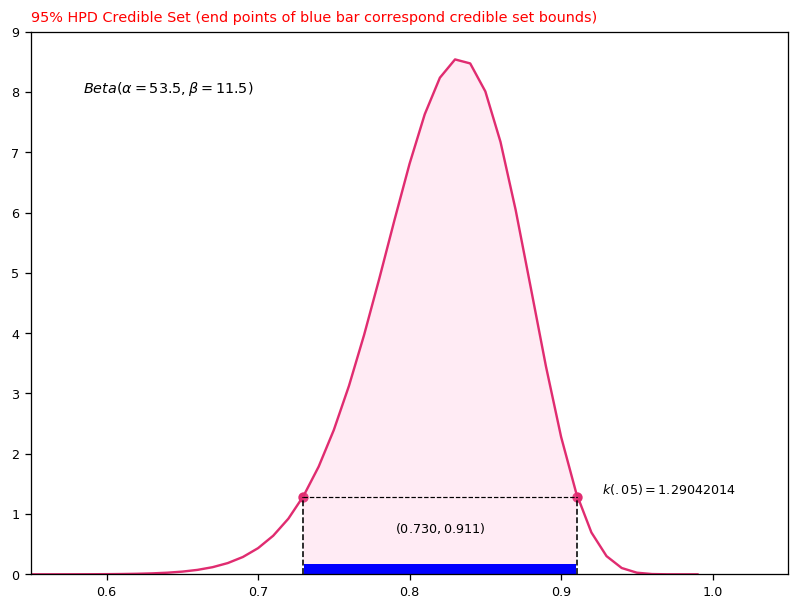

In [3]:
"""
Visualize the (1 - alpha)100% HPD credible set. 
"""
x  = np.arange(0, rv.ppf(1), .01, dtype=np.float32)
y  = rv.pdf(x)
yl = np.asarray([y.max() / 50. for i in x], np.float32) # Used to represent credible set span

titlestr = "95% HPD Credible Set (end points of blue bar correspond credible set bounds)"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8.5, 6.25), dpi=115) 

ax.plot(x, y, color="#E02C70")
ax.scatter(kroots[0], kalpha, s=30, color="#E02C70")
ax.scatter(kroots[-1], kalpha, s=30, color="#E02C70")

ax.plot([kroots[0], kroots[0]], [0, kalpha], linestyle="--", 
        linewidth=1.0, color="#000000")
ax.plot([kroots[-1], kroots[-1]], [0, kalpha], linestyle="--", 
        linewidth=1.0, color="#000000")
ax.plot([kroots[0], kroots[-1]], [kalpha, kalpha], linestyle="--", 
        linewidth=.75, color="#000000")

ax.set_ylim(bottom=0, top=9)
ax.set_xlim(.55, 1.05)


ax.fill_between(x, y, where=np.logical_and(x<=kroots[-1], x>=kroots[0]), 
                facecolor="#ff9ccb", alpha=0.20)
ax.fill_between(x, yl, where=np.logical_and(x<=kroots[-1], x>=kroots[0]), 
                facecolor="blue", alpha=1.)

ax.set_title(titlestr, color="red", loc="left", fontsize=9)
ax.tick_params(axis="x", which="major", labelsize=8)
ax.tick_params(axis="x", which="minor", labelsize=8)
ax.tick_params(axis="y", which="major", labelsize=8)
ax.tick_params(axis="y", which="minor", labelsize=8)
ax.grid(False)

# Embed value of k(alpha).
ax.annotate(
    r"$k(.05)={:.8f}$".format(kalpha), (kroots[-1], kalpha), xytext=(57.5, 0), 
    textcoords="offset points", ha="center", va="bottom", fontsize=8, 
    rotation=0, color="#000000"
    )

# Overlay (1 - alpha)100% HPD credible set.
ax.annotate(
    r"$({:.3f}, {:.3f})$".format(kroots[0], kroots[-1]), 
    ((kroots[0] + kroots[-1]) / 2., kalpha / 2.), xytext=(0, 0), 
    textcoords="offset points", ha="center", va="bottom", 
    fontsize=8, rotation=0, color="#000000"
    )

# Overlay parameters of posterior gamma distribution from HW3 problem 1.c.
ax.annotate(
    r'$Beta(\alpha=53.5, \beta=11.5)$', (rv.ppf(.0005), y.max() * .925), 
    xytext=(0, 0), textcoords="offset points", ha="center", va="bottom", 
    fontsize=9, rotation=0, color="#000000"
    )

plt.show()


## Results

---
- $k(.05) \approx 1.29042014$.         
<br>  
- 95% HPD credible set: $[0.72978, 0.91072]$.        
<br>        
- Credible set span: $L =  0.91072 - 0.72978 \approx .18094$.       
---
